In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [43]:
n_samples = 4
n_length = 100

x_batch = np.random.normal(size=(n_samples, n_length)).astype(np.float32)
y_batch = np.zeros((n_samples, n_length)).astype(np.int32)
for i in range(n_samples):
    start = np.random.choice(n_length // 2)
    end = start + np.random.choice(n_length // 2)
    if i < n_samples//2:
        y_batch[i, start:end+1] = 1

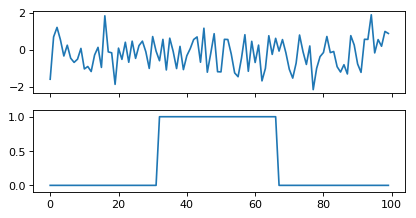

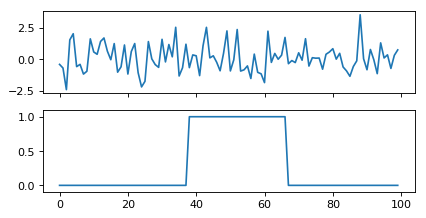

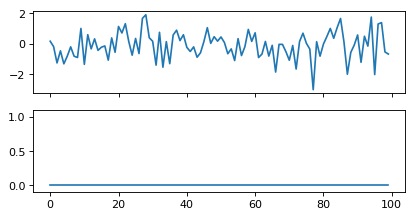

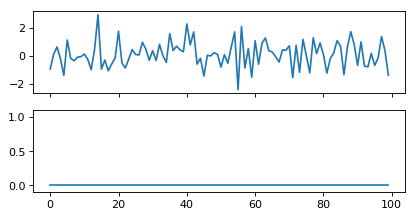

In [45]:
for i in range(n_samples):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 3), dpi=80)
    ax[0].plot(x_batch[i, ...])
    ax[1].plot(y_batch[i, ...])
    ax[1].set_ylim([-0.1, 1.1])
    plt.show()


In [56]:
tf.reset_default_graph()
x = tf.placeholder(shape=[None, n_length], dtype=tf.float32)
y = tf.placeholder(shape=[None, n_length], dtype=tf.int32)

out = x - 1

# weight_negative = 0.5
# weight_positive = 2.0
# class_weights = tf.stack([weight_negative, weight_positive], axis=0)
# weights = tf.gather(class_weights, y)

n_negative = tf.cast(tf.reduce_sum(1 - y), dtype=tf.float32)
n_positive = tf.cast(tf.reduce_sum(y), dtype=tf.float32)

p_drop_negative = (n_negative - n_positive) / n_negative  # in (0, 1)
uniform_random = tf.random.uniform(
    tf.shape(out),
    minval=0.0,
    maxval=1.0,
    dtype=tf.float32)
keep_negative = tf.cast(tf.math.greater(uniform_random, p_drop_negative), dtype=tf.float32)
keep_positive = tf.ones(tf.shape(keep_negative))
keep_stacked = tf.stack([keep_negative, keep_positive], axis=2)

# prepare row indices
row_indices = tf.range(tf.shape(indices)[0])

# zip row indices with column indices
full_indices = tf.stack([row_indices, indices], axis=1)

# retrieve values by indices
S = tf.gather_nd(A, full_indices)


print(keep_overall)

loss_per_sample = keep_overall

# loss_per_sample = out ** 2 * weights
total_loss = tf.reduce_sum(loss_per_sample) / n_length

sess = tf.Session()

tf.global_variables_initializer()

np_loss_per_sample = sess.run(loss_per_sample, feed_dict={y: y_batch, x: x_batch})

Tensor("stack:0", shape=(?, 100, 2), dtype=float32)


NameError: name 'keep_overall' is not defined

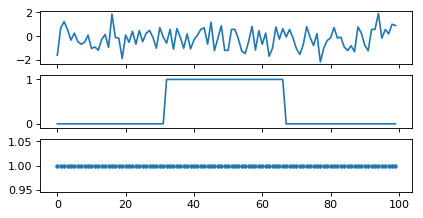

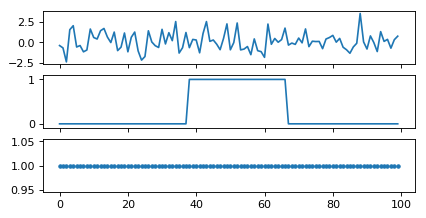

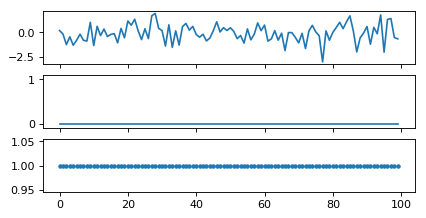

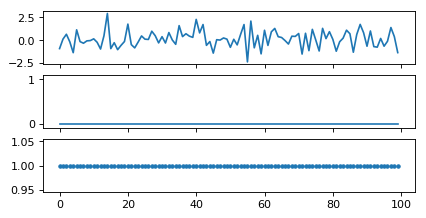

In [53]:
for i in range(n_samples):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(6, 3), dpi=80)
    ax[0].plot(x_batch[i, ...])
    ax[1].plot(y_batch[i, ...])
    ax[1].set_ylim([-0.1, 1.1])
    ax[2].plot(np_loss_per_sample[i, ...], '.')
    plt.show()